In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Piecewise Linear Interoplation (Interpolation Code 0)

References: https://cds.cern.ch/record/1456844/files/CERN-OPEN-2012-016.pdf

We wish to understand interpolation using the piecewise linear function defined as (nb: vector denotes bold)

$$
\eta_s (\vec{\alpha}) = \sigma_{sb}^0(\vec{\alpha}) + \underbrace{\sum_{p \in \text{Syst}} I_\text{lin.} (\alpha_p; \sigma_{sb}^0, \sigma_{psb}^+, \sigma_{psb}^-)}_\text{deltas to calculate}
$$

with

$$
I_\text{lin.}(\alpha; I^0, I^+, I^-) = \begin{cases} \alpha(I^+ - I^0) \qquad \alpha \geq 0\\ \alpha(I^0 - I^-) \qquad \alpha < 0 \end{cases}
$$

In this notebook, we'll demonstrate the technical implementation of these interplatinos starting from simple dimensionality and increasing the dimensions as we go along. In all situations, we'll consider a single systematic that we wish to interpolate, such as Jet Energy Scale (JES).

Let's define the interpolate function. This function will produce the deltas we would like to calculate and sum with the nominal measurement to determine the interpolated measurements value.

In [43]:
def interpolate_deltas(down,nom,up,alpha):
    delta_up = up - nom
    delta_down = nom - down
    if alpha > 0:
        return delta_up*alpha
    else:
        return delta_down*alpha

## The Single Bin Case

Let's first start with considering evaluating the total number of events after applying JES corrections. This is the single-bin case. Code that runs through event selection will vary the JES parameter and provide three histograms, each with a single bin. These three histograms represent the nominal-, up-, and down- variations of the JES nuisance parameter.

When processing, we find that there are 10 events nominally, and when we vary the JES parameter downwards, we only measure 8 events. When varying upwards, we measure 15 events.

In [44]:
down_1 = np.array([8])
nom_1  = np.array([10])
up_1   = np.array([15])

We would like to generate a function $f(\alpha_\text{JES})$ that linearly interpolates the number of events for us so we can scan the phase-space for calculating PDFs. The `interpolate_deltas()` function defined above does this for us.

In [45]:
alphas = np.linspace(-1.,1.)
deltas = [interpolate_deltas(down_1,nom_1,up_1,alpha) for alpha in alphas]
deltas[:5]

[array([-2.]),
 array([-1.91836735]),
 array([-1.83673469]),
 array([-1.75510204]),
 array([-1.67346939])]

So now that we've generated the deltas from the nominal measurement, we can plot this to see how the linear interpolation works in the single-bin case, where we plot the measured values in black, and the interpolation in dashed, blue.

Text(0,0.5,'Events')

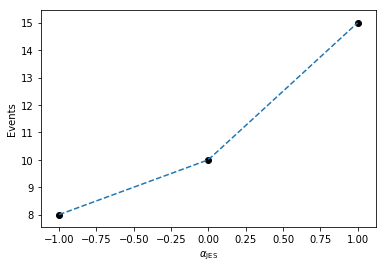

In [63]:
plt.plot(alphas,[nom_1+delta for delta in deltas], linestyle='--')
plt.scatter((-1,0,1),(down_1,nom_1,up_1), color='k')
plt.xlabel(r'$\alpha_\mathrm{JES}$')
plt.ylabel(r'Events')

## Multi-bin Case (interpolating a logical Histogram from three Measurements)

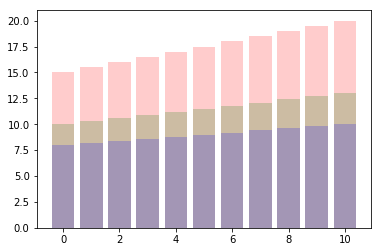

In [4]:
histogram_down = np.linspace(8,10,11)
histogram_nom = np.linspace(10,13,11)
histogram_up = np.linspace(15,20,11)

bincenters = np.arange(len(histogram_nom))
for c,h in zip(['r','g','b'],[histogram_up,histogram_nom,histogram_down]):
    plt.bar(bincenters,h, alpha = 0.2, facecolor = c)

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### At a single alpha value alpha = 0.5

In [6]:
histogram_down = np.linspace(8,10,11)
histogram_nom = np.linspace(10,13,11)
histogram_up = np.linspace(15,20,11)


from ipywidgets import interact

def plot_interpolated_histogram(alpha):
    interpolated = [nom + interpolate(dn,nom,up,alpha) for dn,nom,up in zip(histogram_down,histogram_nom,histogram_up)]
    bincenters = np.arange(len(interpolated))
    for c,h in zip(['k','#222222','#444444'],[histogram_up,histogram_nom,histogram_down]):
        plt.bar(bincenters,h, alpha = 0.2, facecolor = c)
    plt.bar(bincenters,interpolated, facecolor = 'r', alpha = 0.2)

x = interact(plot_interpolated_histogram,alpha = (-1,1,0.2))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMCwgZGVzY3JpcHRpb249dSdhbHBoYScsIG1heD0xLjAsIG1pbj0tMS4wLCBzdGVwPTAuMiksIE91dHB1dCgpKSwgX2TigKY=


### At a multiple alpha values alpha = [-1,....,1]

In [7]:
alphas = np.linspace(-1,1,11)

at_alphas = []

for alpha in alphas:
    inerpolated_hist = [nom + interpolate(dn,nom,up,alpha) for dn,nom,up in zip(histogram_down,histogram_nom,histogram_up)]
    at_alphas.append(inerpolated_hist)

In [11]:
# setup the figure and axes

# fake data
x,y = np.meshgrid(bincenters,alphas)

top = np.asarray(at_alphas).ravel()
bottom = np.zeros_like(top)
width = depth = 1
def plot_wire(index):
    sl = slice(index,index+1)
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_wireframe(x, y,top.reshape(len(bincenters),len(alphas)), alpha = 0.3)
    ax1.plot_wireframe(x[sl], y[sl],top.reshape(len(bincenters),len(alphas))[sl], edgecolor = 'r')
    ax1.set_zlim(0,25)
    ax1.view_init(azim=-125)
    plt.show()
interact(plot_wire,index = (0,5))

interactive(children=(IntSlider(value=2, description='index', max=5), Output()), _dom_classes=('widget-interac…

<function __main__.plot_wire(index)>